In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
df = pd.read_csv('CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv', parse_dates=['date'])
df = df[(df.date.dt.year > 2001) & (df.date.dt.year < 2018)] # only include up to 2016, with 2017 being the test set

---
# Exploratory Data Analysis

What are the characteristics of the data?

In [2]:
# there are three different dtypes
df.dtypes

station_id              int64
stationname            object
date           datetime64[ns]
daytype                object
rides                   int64
dtype: object

## stationname

In [3]:
# check correlation between station id and station name
# ensure that they are correlated and use the station_id for model training
df[['stationname','station_id']].corr()

,station_id
station_id,1.0


In [4]:
print('Total unique Station Names: {}'.format(len(df.stationname.unique())))

Total unique Station Names: 147


In [5]:
mean_by_station = df.groupby('stationname').rides.mean().mean()
print('The average ride by stationname across all years: {}'.format(round(mean_by_station)))

The average ride by stationname across all years: 3316.0


The stations with really high ridership over the years


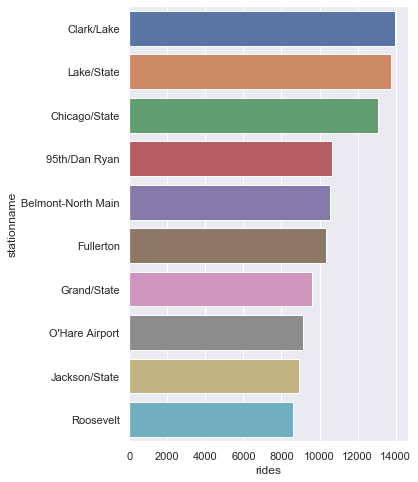

In [6]:
print('The stations with really high ridership over the years')
a0 = df.groupby('stationname').rides.mean().sort_values(ascending=False).head(10).round()
a0 = pd.DataFrame(a0)
sns.set(rc={'figure.figsize':(5,8)})
sns.barplot(x='rides', y=a0.index, data=a0, orient='h')

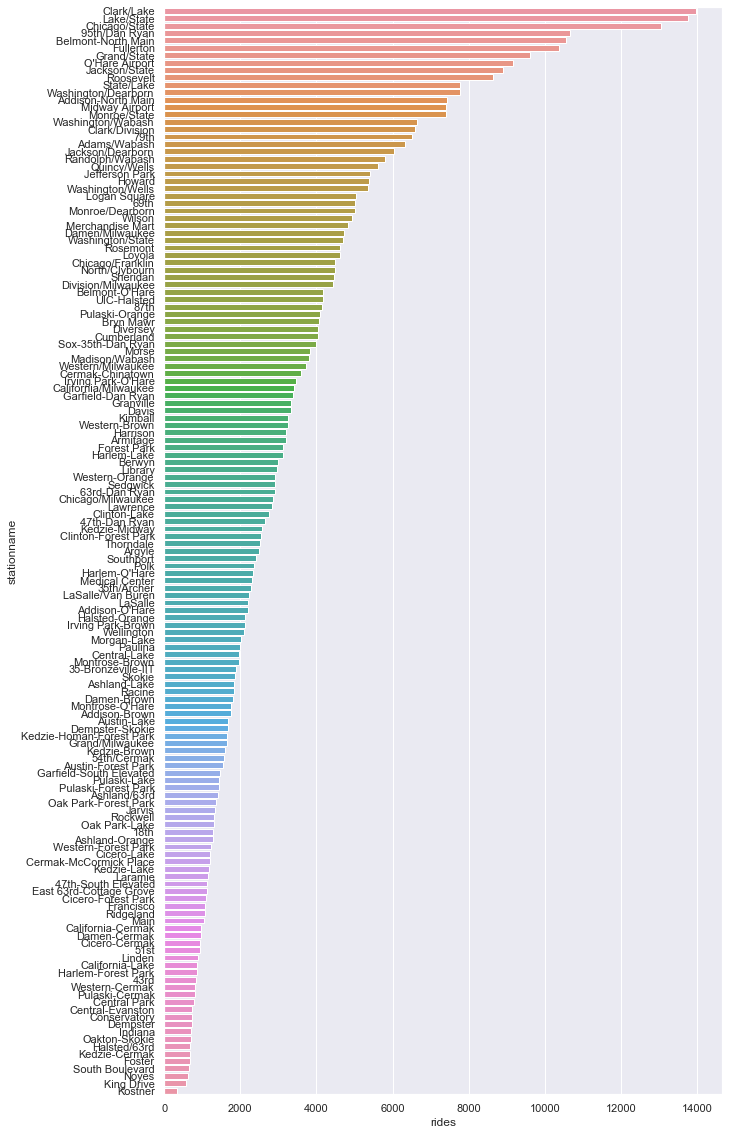

In [7]:
# all stations and the average ridership over the years
# would be interesting to plot this geographically
a1 = pd.DataFrame(df.groupby('stationname').rides.mean().sort_values(ascending=False))
sns.set(rc={'figure.figsize':(10,20)})
sns.barplot(x='rides', y=a1.index, data=a1)

## date

In [8]:
# date range
df.date.min(), df.date.max()

(Timestamp('2002-01-01 00:00:00'), Timestamp('2017-12-31 00:00:00'))

In [9]:
# create a year, month, and day columns
df = df.assign(year=df.date.dt.year)
df = df.assign(month=df.date.dt.month)
df = df.assign(day=df.date.dt.day)

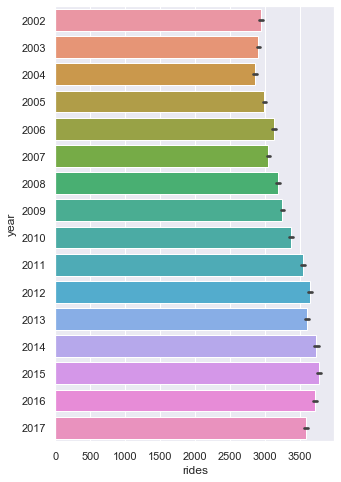

In [10]:
# mean rides by year
sns.set(rc={'figure.figsize':(5,8)})
sns.barplot(x='rides', y='year', data=df, orient='h')

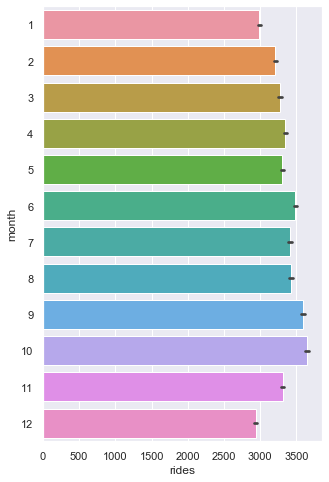

In [11]:
# mean rides by month
sns.set(rc={'figure.figsize':(5,8)})
sns.barplot(x='rides', y='month', data=df, orient='h')

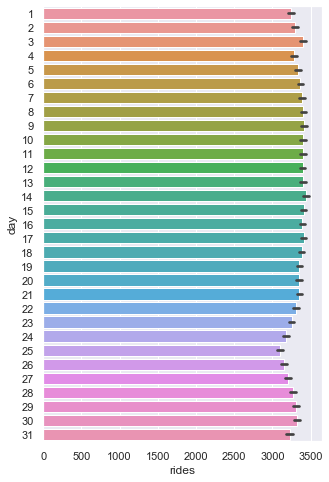

In [12]:
sns.set(rc={'figure.figsize':(5,8)})
sns.barplot(x='rides', y='day', data=df, orient='h')

## daytype

In [ ]:
# most of the data is in the weekdays
sns.set(rc={'figure.figsize':(3,3)})
sns.barplot(x='daytype',y='rides', data=df)

## rides

In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
sns.distplot(df.rides, kde=False)
plt.axvline(df.rides.median(),0,2)
print('Median ride {}'.format(df.rides.median()))

In [ ]:
# plot rides by station and year
def plot_ride_years(name, start_year, end_year):
    sns.set(rc={'figure.figsize':(20,10)})
    year_list = []
    for y in range(start_year,end_year):
        year_list.append(str(y))
        tmp = df[(df.stationname == name) & (df.date.dt.year == y)].sort_values(by='date')
        sns.lineplot(x='month',y='rides',data=tmp)
    plt.legend(labels=year_list)

In [ ]:
plot_ride_years('Clark/Lake', 2010, 2016)

In [ ]:
plot_ride_years('Belmont-North Main', 2010, 2016)

In [ ]:
# plot rides by station and month between the years 2001 and 2016
def plot_ride_month(name, month):
    sns.set(rc={'figure.figsize':(20,10)})
    year_list = []
    for y in range(2002,2016):
        #print(y)
        year_list.append(str(y))
        tmp = df[(df.stationname == name) & (df.date.dt.year == y) & (df.date.dt.month == month)].sort_values(by='date')
        sns.lineplot(x='day',y='rides',data=tmp)
    plt.legend(labels=year_list)

In [ ]:
plot_ride_month('Clark/Lake', 6)

In [ ]:
plot_ride_month('Belmont-North Main', 6)

### Q: What are your findings?


There are three stations that have really high ridership among the 148 stations: 1) Clark/Lake 2) Lake/State 3) Chicago/State.

The year 2015 had the highest ridership averaged across all stations. This metric generally increased from 2001 to 2015. After 2015, the values began to drop.

October is the busiest month and things slow down from late Fall to early Winter.

There's an interesting dip in ridership towards the end of the Month, that starts at day 20 recovers by day 30.

### Q: What did you learn from the data?

Different stations have different temporal profiles of ridership. Some stations have characteristic ride volumes viewed at a year window and/or at a day in month view.

The ride volume is right skewed and with a high kurtosis. This is probably due to certain stations handling and contributing the high ride volumen than other stations.

---
# Predictive Model

### Q: The transportation department wants to improve service in the next few years. Can you build a model for them to forecast daily rides? (Please use 2017 data as testing set for evaluation)
The following code below demonstrates the use of a logistic regression and an recurrent neural network model.

### Q: Which aspects should you consider for this model? _Please explain how you built the model and justify the choices you made._
I've considered the the rides with respect to the daytype and decomposition of the date into month, and day values. Since each station exhibits different ride characteristics, it's probably best to separate and train according to the station of interest. The year wasn't considered since it's been instructed that the year 2017 serves as a test set.

Initially, I used a linear model to see how any given day for a certain station would be for predictin ridership. For the linear regression model, I focused on the Belmont-North Main station and used the daytype, year, day, and month columns. This resulted in a large R2 loss, and it made sense to incorporate multiple dates to forecast ridership the next day.

I then used a simple RNN, as an improvement to the linear model to consider 5 days worth of data to predict rides for the next day. I used the same features as described above and used Belmont-North Main station as an example.

In [ ]:
# encode the daytype column
le = preprocessing.LabelEncoder()
df = df.assign(daytype_id=le.fit_transform(df.daytype.values))
df.head()

In [ ]:
# look at one station
# I picked Belmont-North Main because it had an interesting spike in ridership in June
df = df[df.stationname == 'Belmont-North Main'].reset_index(drop=True)

In [ ]:
# create train and test set
# indices with dates other than 2017
train_idx = df.date[df.date.dt.year != 2017].index
# make the splits
train = df.iloc[ train_idx ]
test  = df[ ~df.index.isin(train_idx) ]
print('Training set shape: {}\nTest set shape: {}'.format(train.shape, test.shape))

## Linear

In [ ]:
# linear regression

feature_columns = ['month', 'day', 'daytype_id']

X = train[feature_columns].values
y = train.rides.values

X_test = test[feature_columns].values
y_test = test.rides.values

regr = LinearRegression()
regr.fit(X,y)

In [ ]:
pred = regr.predict(X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, pred))

## RNN

In [ ]:
train2 = train.copy()
train2 = train2.sort_values(by='date').reset_index(drop=True)

test2 = test.copy()
test2 = test2.sort_values(by='date').reset_index(drop=True)

# normalize
train_mean = train2.rides.mean()
train_std  = train2.rides.std()
train2.rides = train2.rides.subtract(train_mean).divide(train_std)
train2.month = train2.month.subtract(train2.month.mean()).divide(train2.month.std())
train2.day   = train2.day.subtract(train2.day.mean()).divide(train2.day.std())

test_mean = test2.rides.mean()
test_std  = test2.rides.std()
test2.rides = test2.rides.subtract(test_mean).divide(test_std)
test2.month = test2.month.subtract(test2.month.mean()).divide(test2.month.std())
test2.day   = test2.day.subtract(test2.day.mean()).divide(test2.day.std())
# define features
# feature_columns = ['rides', 'station_id', 'year', 'month', 'day', 'daytype_id']
feature_columns = ['rides', 'month', 'day', 'daytype_id']

In [ ]:
%%capture
from tqdm.notebook import tqdm

In [ ]:
# preprocess the data so that each training example is a group of 5 days worth of data
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in tqdm(range(start_index, end_index)): # take out the tqdm parentheses if tqdm is not installed correctly
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        #data.append(np.reshape(dataset.iloc[indices].values, (history_size, 1)))
        data.append(dataset.loc[indices,feature_columns].values)
        labels.append(dataset.loc[i+target_size, 'rides'])
    return np.array(data), np.array(labels)

x_train, y_train = univariate_data(train2, 0, None, 5, 1)
x_test, y_test   = univariate_data(test2, 0, None, 5, 1)

In [ ]:
BATCH_SIZE = 5
BUFFER_SIZE = 100

train_univariate = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_univariate = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_univariate = test_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [ ]:
# this block of code is to help visualize the segment of data
# and ground truth rides or forecast of rides the next day

def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                     label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

In [ ]:
# test plot
show_plot([x_test[20][:,0], y_test[20]],0,'ex')

In [ ]:
# build an eight unit rnn model
simple_rnn_model = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(8, input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_rnn_model.compile(optimizer='adam', loss='mae')

In [ ]:
# train the model
EVALUATION_INTERVAL = x_train.shape[0] // BATCH_SIZE
EPOCHS = 10

history = simple_rnn_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=test_univariate, validation_steps=50)

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Visualize the predictions with respect to the actual values of 5 cases or time windows
for x, y in test_univariate.take(5):
    plot = show_plot([x[0][:, 0].numpy(), y[0].numpy(),
                    simple_rnn_model.predict(x)[0]], 0,
                   'Single Step Prediction')
    plot.show()

### Q: How would you evaluate this model to ensure it would be robust for production usage?

As new data is accumulated, I would retrain a new model with the additional data and compare the loss to the model already in production. I would then update the production model only if the model trained with the additional data produced lower training and validation loss without overfitting.

I would also increase the sampling of train and test data splits and look at the distribution of the MAE loss at the end of training. Methods I would use is k-fold or jackknife sampling.

In terms of how well the model is predicting rides at each window of time, I would accumulate the error across all predictions in the test set and see the average and standard deviation of that error.